# Tracking candidate paths from multi-path exploration

In [235]:
import sys
sys.path.append('../')
from panav.viz import draw_env
from panav.multi_path import explore_multi_path
from panav.env import NavigationEnv,box_2d_center,Box2DRegion

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Empty Environment

In [244]:

# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 9,-9
start_x_offset = 7
goal_x_offset = 9
N = 5

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

start = np.array(list(starts[-1].centroid().coords)[0])
goal = np.array(list(goals[-1].centroid().coords)[0])

limits = [(-10.0,10.0),(-10.0,10.0)]

# Construct the hybrid graph representation of the environment
bloating_r = 0.5 
env = NavigationEnv(limits,[],starts,goals)

## Double tunnel environment

In [121]:

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-3,-1.0))
O3 = Box2DRegion((-2.5,2.5),(-10.0,-4.0))
env = NavigationEnv(limits,[O1,O2,O3],starts,goals)

# Two Circles

In [245]:
from panav.env import approxCircle
obstacles = []
R = 3

obstacles += approxCircle(np.array([0,5.0]),R)
obstacles += approxCircle(np.array([0,-5]),R)

env = NavigationEnv(limits,obstacles,starts,goals)

# Explore candidate paths

In [246]:
candidate_paths = explore_multi_path(env,start,goal)

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/cvxpy/problems/problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


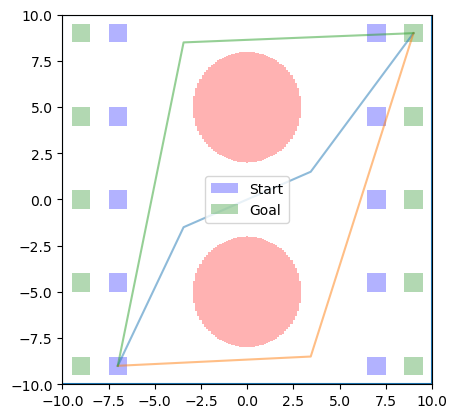

In [247]:
ax = plt.gca()
draw_env(env,candidate_paths,ax)
plt.show()    


In [248]:

import cvxpy as cp
def track_ref_path(env, start, goal,ref_path, vmax, bloating_r, obstacle_trajectories,d, alpha = 0.5):
    K0 = ref_path.shape[1]-1
    ref_curve = ParametericCurve(ref_path)
    for K in range(K0,K0+5):
        print(K)
        ref_points = np.array([ref_curve(t) for t in np.linspace(0,1,K+1)]).T

        t,x,constraints = Standard_Tube_Var_Constraints(env, start, goal,vmax, bloating_r,obstacle_trajectories, d, K)

        tracking_loss = cp.norm(x-ref_points,'fro')
        prob = cp.Problem(cp.Minimize(alpha*tracking_loss+(1-alpha)*t[0,-1]),constraints)
        prob.solve()
        print(tracking_loss.value, t.value[0,-1])
        if t.value is not None:
            return t.value[0,:],x.value
    return None

# Generate moving obstacles

In [249]:
from panav.SAMP import Tube_Planning
from panav.util import unique_tx
from time import time
agents = range(N*2-1)
plan = []
times = []
success = True
fail_time = None
for agent in agents:
    print(agent)
    t0 = time()

    
    start = env.starts[agent]
    goal = env.goals[agent]

    agent_success = False
    
    
    for K in range(1,8):
        print("K",K)
        results = Tube_Planning(env,start, goal, 1.0 , bloating_r, 
                                obs_trajectories=plan, 
                                d=2, K=K,
                                ignore_finished_agents = False)

        if results is not None:
            t,xs = results
            times.append(time()-t0)
            print(times[-1])
            t,xs = unique_tx(t,xs)
            plan.append((t,xs))
            agent_success = True
            break
        

    if not agent_success:
        print("Solution failed.")
        success = False
        times.append(time()-t0)
        break


0
K 1
K 2
0.47383594512939453
1
K 1
K 2
K 3
0.6569218635559082
2
K 1
K 2
0.4765040874481201
3
K 1
K 2
K 3
K 4
1.1624581813812256
4
K 1
K 2
K 3
0.8802309036254883
5
K 1
K 2
K 3
1.0120136737823486
6
K 1
K 2
K 3
K 4
1.6726899147033691
7
K 1
K 2
K 3
K 4
5.09559178352356
8
K 1
K 2
K 3
K 4
K 5
4.438449144363403


3
1.2117095414763188 38.805450813289745


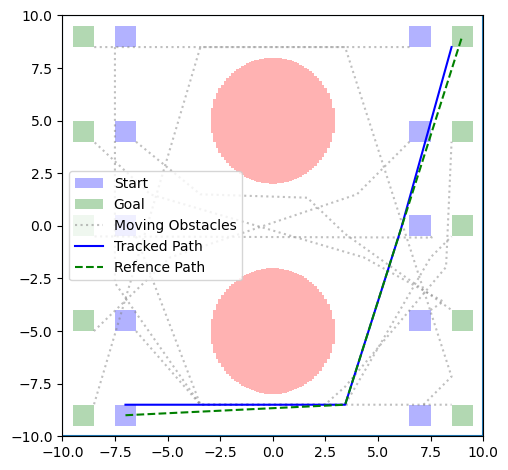

In [250]:
from panav.SAMP import track_ref_path

obstacles = [x for t,x in plan]
ref_path = candidate_paths[1]

vmax = 1.0
bloating_r = 0.5
# obstacle_trajectories = plan
obstacle_trajectories = []

d = 2
t, tracked_path = track_ref_path(env,starts[-1],goals[-1],ref_path,1.0,0.5, obstacle_trajectories,2,alpha = 1e5)
ax = plt.gca()
draw_env(env,[],ax)

for a in range(len(obstacles)):    
    ax.plot(obstacles[a][0,:],obstacles[a][1,:],color = 'gray',ls = "dotted",alpha = 0.5,
            label = "Moving Obstacles" if a==0 else None)


ax.plot(tracked_path[0,:],tracked_path[1,:],color = 'blue',label = 'Tracked Path')
ax.plot(ref_path[0,:],ref_path[1,:],color = 'green',label = 'Refence Path',ls='dashed')
# ax.plot(tracked_path[0,:],tracked_path[1,:],color = 'blue',label = 'Tracked Path')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/TrackingReferencePath.png')
plt.show()    
